# Kaggle - Sentiment Analisis in Movie Reviews

Source: https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data

In [35]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# Util function for ploc roc

In [17]:
def plot_roc(model, x_columns, y_true, size_x=12, size_y=12):
    """Returns a ROC plot

    Forked from Matt Drury.
    """

    y_pred = model.predict_proba(x_columns)

    fpr, tpr, threshold = roc_curve(y_true, y_pred[:, 1])
    area_under_curve = auc(fpr, tpr)

    # method I: plt
    fig, ax = plt.subplots(figsize=(size_x, size_y))
    model_name = str(type(model)).split('.')[-1].strip(">\'")
    plt.title(f'{model_name} ROC')
    ax.plot(fpr, tpr, 'k', label='AUC = %0.3f' % area_under_curve)

    ax.legend(loc='lower right')
    ax.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Create a model class to wrapper Tfid vectorizer and the multinomialNB

In [21]:
class NLPModel(object):

    def __init__(self):
        """Simple NLP
        Attributes:
            clf: sklearn classifier model
            vectorizor: TFIDF vectorizer or similar
        """
        self.clf = MultinomialNB()
        # self.vectorizer = TfidfVectorizer(tokenizer=spacy_tok)
        self.vectorizer = TfidfVectorizer()

    def vectorizer_fit(self, X):
        """Fits a TFIDF vectorizer to the text
        """
        self.vectorizer.fit(X)

    def vectorizer_transform(self, X):
        """Transform the text data to a sparse TFIDF matrix
        """
        X_transformed = self.vectorizer.transform(X)
        return X_transformed

    def train(self, X, y):
        """Trains the classifier to associate the label with the sparse matrix
        """
        # X_train, X_test, y_train, y_test = train_test_split(X, y)
        self.clf.fit(X, y)

    def predict_proba(self, X):
        """Returns probability for the binary class '1' in a numpy array
        """
        y_proba = self.clf.predict_proba(X)
        return y_proba[:, 1]

    def predict(self, X):
        """Returns the predicted class in an array
        """
        y_pred = self.clf.predict(X)
        return y_pred

    def pickle_vectorizer(self, path='./TFIDFVectorizer.pkl'):
        """Saves the trained vectorizer for future use.
        """
        with open(path, 'wb') as f:
            pickle.dump(self.vectorizer, f)
            print("Pickled vectorizer at {}".format(path))

    def pickle_clf(self, path='./SentimentClassifier.pkl'):
        """Saves the trained classifier for future use.
        """
        with open(path, 'wb') as f:
            pickle.dump(self.clf, f)
            print("Pickled classifier at {}".format(path))

    def plot_roc(self, X, y, size_x=12, size_y=12):
        """Plot the ROC curve for X_test and y_test.
        """
        plot_roc(self.clf, X, y, size_x, size_y)


# Function to build the model

In [22]:
def build_model():
    model = NLPModel()

    with open('./train.tsv') as f:
        data = pd.read_csv(f, sep='\t')

    # only 0 and 4 labels
    pos_neg = data[(data['Sentiment'] == 0) | (data['Sentiment'] == 4)]
    
    # convert to 0 or 1
    pos_neg['Binary'] = pos_neg.apply(
        lambda x: 0 if x['Sentiment'] == 0 else 1, axis=1)

    model.vectorizer_fit(pos_neg.loc[:, 'Phrase'])
    print('Vectorizer fit complete')

    X = model.vectorizer_transform(pos_neg.loc[:, 'Phrase'])
    print('Vectorizer transform complete')
    y = pos_neg.loc[:, 'Binary']

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    model.train(X_train, y_train)
    print('Model training complete')

    model.pickle_clf()
    model.pickle_vectorizer()

    model.plot_roc(X_test, y_test)

C:\Users\MH916XG\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Vectorizer fit complete
Vectorizer transform complete
Model training complete
Pickled classifier at ./SentimentClassifier.pkl
Pickled vectorizer at ./TFIDFVectorizer.pkl


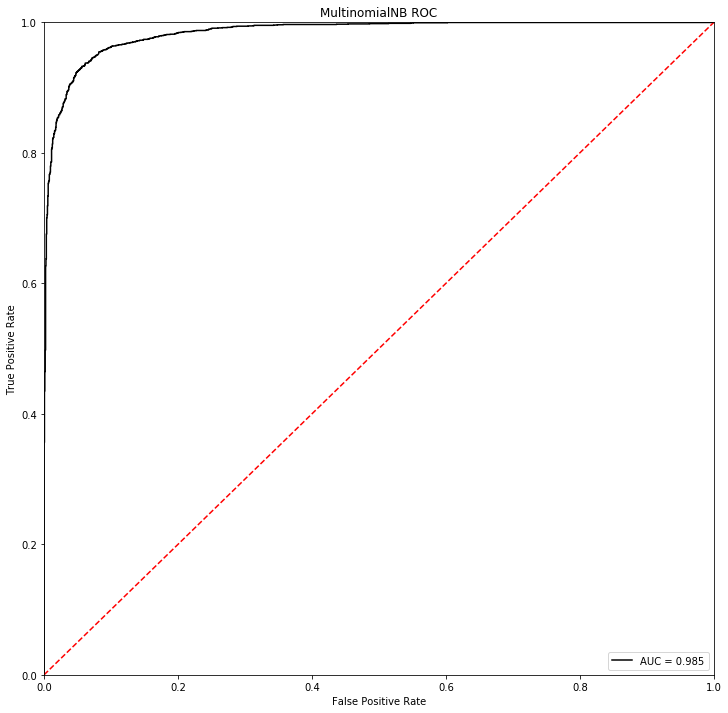

In [23]:
build_model()

# Load pickles into our model class 

In [31]:
model = NLPModel()

clf_path = './SentimentClassifier.pkl'
with open(clf_path, 'rb') as f:
    model.clf = pickle.load(f)

vec_path = './TFIDFVectorizer.pkl'
with open(vec_path, 'rb') as f:
    model.vectorizer = pickle.load(f)

# Helper to get sentiment label, 0 or 1

In [50]:
def get_sentiment(phrase):
    if model.predict(
        model.vectorizer_transform(np.array([phrase]))
    ) == 0:
        sentiment = 'Negative'
    else:
        sentiment = 'Positive'
        
    return sentiment

get_sentiment('I think the movie was a pretty perfect')

'Positive'

# Using the model and test it

In [66]:
with open('./test.tsv') as f:
    data = pd.read_csv(f, sep='\t')
    
head = data[400:500]

head["sentiment"] = head['Phrase'].apply(
    lambda s: get_sentiment(s)
)
    
print(head[['Phrase', 'sentiment']])

                                        Phrase sentiment
400               the supposedly liberal media  Positive
401                   supposedly liberal media  Positive
402                         supposedly liberal  Positive
403                                 supposedly  Negative
404                                    liberal  Positive
..                                         ...       ...
495  is nurturing , in a gauzy , dithering way  Positive
496                             is nurturing ,  Positive
497                               is nurturing  Positive
498                                  nurturing  Positive
499                 in a gauzy , dithering way  Negative

[100 rows x 2 columns]


C:\Users\MH916XG\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
